In [11]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    import matrices_assembly as assembly
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Modules imports were successful!


## Physics Constants

In [12]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0

# 2-noded Linear Elements, $P_1$

In [13]:
FINITE_ELEMENT = ("Triangle", 1)

# BOUNDARY = [{'tag': 101,'type': 'ABC', 'value': None, 'name': 'x0'},
#             {'tag': 102,'type': 'ABC', 'value': None, 'name': 'xL'}]

BOUNDARY = [{'tag': 101,'type': 'Dirichlet', 'value': 0.0, 'name': 'x0'},
            {'tag': 102,'type': 'Dirichlet', 'value': 0.0, 'name': 'xL'}]

MATERIAL = [{'tag': 201, 'name': 'pml',
                'electric_conductivity': 0,
                'relative_magnetic_permeability': 1,
                'relative_electric_permittivity': 1},
            {'tag': 202, 'name': 'free_space',
                'electric_conductivity': 0,
                'relative_magnetic_permeability': 1,
                'relative_electric_permittivity': 1},
            {'tag': 203, 'name': 'lossy_slab',
                'electric_conductivity': 5E-3,
                'relative_magnetic_permeability': 1,
                'relative_electric_permittivity': 2.7}
            ]

INTERFACES = [{'tag': 301, 'type': 'Interface', 'value': None, 'name': 'pml'},
              {'tag': 302, 'type': 'Interface', 'value': None, 'name': 'slab'}]

# Define o domínio do problema
GEOMETRY = {'a': {'h': WAVELENGTH/80, 'L': WAVELENGTH*2, 'd': WAVELENGTH/4}}
GEOMETRY = GEOMETRY['a']

# Criar geometria coaxial
mesh_data = ps.create_p4_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, INTERFACES, GEOMETRY, view_mesh=False)

# Parâmetros do PML
PML_DESIGN = {
    'x0': GEOMETRY['L']/2,  # Interface inicial do PML
    'n': 1.0,               # Ordem polinomial do PML
    'R': 1E-4,              # Coeficiente de reflexão
}

# Aplicar a física do problema
mesh_data = ps.apply_pml_physics(PML_DESIGN, mesh_data)

ElementsDimTags [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
BoundariesDimTags [(0, 1), (0, 6)]
InterfacesDimTags [(0, 2), (0, 3), (0, 4), (0, 5)]
Malha salva em pre_processing/mesh/lossy_dielectric_pml.msh
Model lossy_dielectric_pml (1D)
Info     : 11 geometric entities
Info     : 7 Physical Groups
Info     : 321 nodes in total
Info     : 320 1 elements in total
Sigma_0X: 1.4658711977588554


## Figure 1: Boundary conditions map

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\ozg46_time_harmonic_1d\pre_processing\pictures\coordinates_map_LossySlabDomain.svg


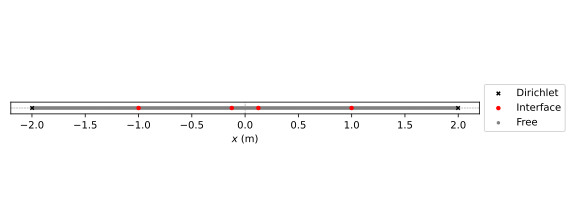

In [14]:
ps.plot_coordinates(mesh_data, Domain='LossySlab')
display(SVG(filename="pre_processing/pictures/coordinates_map_LossySlabDomain.svg"))

## FEM Solution

In [15]:
# Montagem das matrizes globais
Sg, Mg, bg = assembly.global_matrices(mesh_data)

# Aplicar condições de contorno ABC
Sg, Mg, bg = assembly.apply_simple_bcs(Sg, Mg, bg, mesh_data)

# Vetor de potencial global
Ag = Sg + Mg
ug = spsolve(Ag.tocsr(), bg.toarray())
print("Global matrices shape:", Ag.shape)
print("Global Potencial Vector shape:", ug.shape)

Applying Dirichlet at node 1 with value 0
Applying Dirichlet at node 6 with value 0
Global matrices shape: (321, 321)
Global Potencial Vector shape: (321,)


## Post-Processing

In [16]:
# Dicionário com os resultados
uh = {key+1: value for key, value in enumerate(ug)}

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\ozg46_time_harmonic_1d\pos_processing\pictures\fem_solution_abs_Computational_PmlDielectricSlab.svg


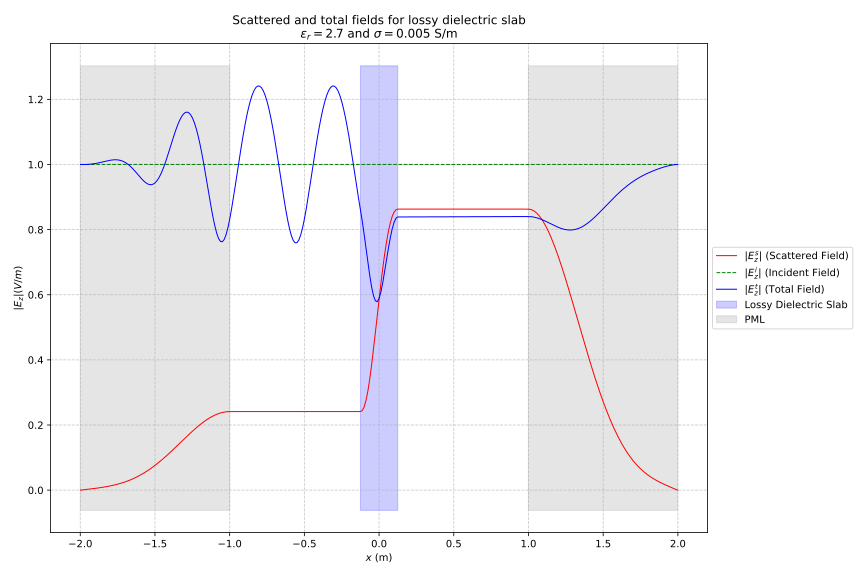

In [17]:
ps.plot_fem_pml_solution(MATERIAL[2], mesh_data, uh, Name='PmlDielectricSlab')
display(SVG(filename="pos_processing/pictures/fem_solution_abs_Computational_PmlDielectricSlab.svg"))

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\ozg46_time_harmonic_1d\pos_processing\pictures\fem_solution_abs_Physical_PmlDielectricSlab.svg


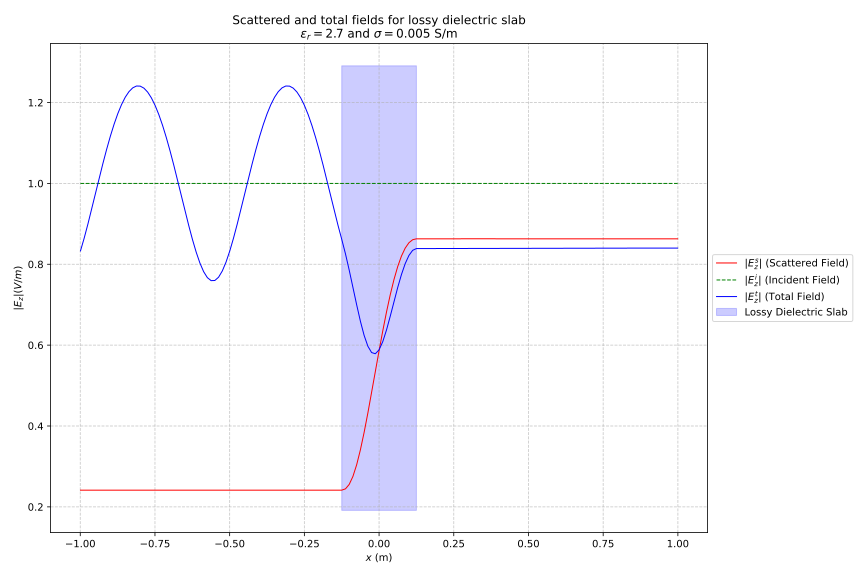

In [18]:
ps.plot_fem_pml_solution(MATERIAL[2], mesh_data, uh, Name='PmlDielectricSlab', Domain='Physical')
display(SVG(filename="pos_processing/pictures/fem_solution_abs_Physical_PmlDielectricSlab.svg"))

### Reflection and Transmission Coefficients

In [19]:
from collections import OrderedDict
interface_nodes = OrderedDict()

# Coeficientes de reflexão e transmissão
for key, node in mesh_data['nodes'].items():
    if node['bc']['name'] == 'pml':
        interface_nodes[key] = node

for key, node in interface_nodes.items():
    if node['xg'][0] < 0:
        R_coeff = np.abs(uh[key])
        print(f"R_coeff = {R_coeff:.4f}")
    else:
        u_inc = np.exp(-1j * K0 * node['xg'][0])
        T_coeff = np.abs(u_inc + uh[key])
        print(f"T_coeff = {T_coeff:.4f}")

R_coeff = 0.2413
T_coeff = 0.8400


Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.